> *Reference*: https://www.clairvoyant.ai/blog/emotion-recognition-with-deep-learning-on-google-colab

# **Initializing project**

In [1]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/EmotionRecognition/EmotionRecognitionData.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")

Done


In [81]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.models import load_model, Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.optimizers import Adam

#**Initializing Training and Test Generators**

## Thuật ngữ
* **Tensor**: Kiểu dữ liệu dạng ma trận từ 3 chiều trở lên

* **Data augmentation**: Khởi tạo thêm dữ liệu bằng cách áp dụng (ngẫu nhiên) transformation (rotate, flip, noise, etc.) lên dữ liệu cho trước

* **One-hot encode**: Phân loại dữ liệu bằng độ tương đồng của mẫu với từng category

## Hàm
**[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)**: Khởi tạo các batch tensor kiểu hình ảnh (3D) với data augmentation thời gian thực

* **[flow_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe)**: tạo batch từ dataset lưu trong địa chỉ
    * **target_size**: các hình ảnh được nạp vào sẽ được resize về kích thước này
    * **class_mode = 'categorical'**: dùng mã hóa one-hot 2D với các category là các top-level subfolder

In [3]:
train_dir = 'train'
val_dir = 'test'

train_img_datagen = ImageDataGenerator(rescale = 1./255)
val_img_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_img_datagen.flow_from_directory (
    train_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

val_set = val_img_datagen.flow_from_directory (
    val_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Building the Convolutional Neural Network (CNN) Model**

## Thuật ngữ
**[Highway nework](https://wikiless.tiekoetter.com/wiki/Highway_network?lang=en)**: Mạng neuron truyền thẳng kích thước lớn với khả năng skip layer. Có 3 gates: H, T, C

**[ResNet](https://wikiless.tiekoetter.com/wiki/Residual_neural_network?lang=en)**: (Residual Network) biến thể gateless của Highway network với khả năng skip 2-3 layers

**[Convolution](https://developers.google.com/machine-learning/glossary/#convolutional)**: (Tích chập) Dùng các filter và layer tích chập để train weight trên ma trận đầu vào
* **Filter**: một ma trận được seed với 0 và 1 có cùng số chiều với input nhưng kích thước nhỏ hơn, dùng để train model
* **Layer**: lớp của mạng neuron để conv. filter thực hiện tích chập (**nhân filter với _slice_** của layer đang được filter đè lên **và lấy tổng** của ma trận kết quả)

**[Pooling](https://developers.google.com/machine-learning/glossary/#pooling)**: Giảm kích thước ma trận tích chập

**[Dropout](https://developers.google.com/machine-learning/glossary/#dropout-regularization)**: Phương pháp tinh giản mạng bằng cách loại ngẫu nhiên các tập hợp có-kích-thước-định-trước các đơn vị của từng lớp của mạng

**[Fully connected layer](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)**: (aka. **dense layer**) Là một hidden layer có liên kết với mọi node của hidden layer sau nó

**[Loss](https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss)**: Chỉ số độ thiếu chính xác của model

## Hàm
**[ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)**: Khởi tạo mạng ResNet 50 layers
* **input_shape**: kích thước tensor
    * **`(48, 48, 3)`**: kích thước 48*48px với 3 kênh input (R-G-B), format `channels_last`
* **include_top**: include top-level dense layer (???)
    * Phải là `False` thì mới có thể cài đặt `input_shape`
* **weight = 'imagenet'**: Dùng dữ liệu pre-train từ ImageNet

**[Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)**: Nhóm một tập hợp tuyến tính các activation layers

**[Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)**: convert ma trận về dạng mảng 1 chiều

In [4]:
# Khởi tạo khung mạng
base_model = tf.keras.applications.ResNet50(input_shape = (48, 48, 3),
                                            include_top = False,
                                            weights = 'imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [5]:
# Khởi tạo model
model = Sequential()

# Dùng khung mạng ResNet đã tạo
model.add(base_model)

# Khởi tạo các hàm activation cho model
model.add(Conv2D(filters = 32,
                 kernel_size = (3, 3),
                 padding = 'same',
                 data_format = 'channels_last',
                 activation = 'relu',
                 input_shape = (48, 48, 3)))
model.add(Conv2D(filters = 64,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.25))                        # (64/4) * (64/4) = 512

model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
model.add(Conv2D(filters = 128,
                 kernel_size = (3, 3),
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))

model.add(Dropout(0.25))                        # (128/4) * (128/4) = 1024

model.add(Flatten())                            # Convert tensor về mảng 1 chiều

model.add(Dense(1024, activation='relu'))       # Layer dense với 1024 nodes nối mảng 1 chiều ở trên với layer tiếp theo
model.add(Dropout(0.5))                         # Xét 512 neuron của layer dense bên trên

model.add(Dense(7, activation='softmax'))       # Layer dense với 7 nodes emotions

In [6]:
# Cài đặt model để chuẩn bị train
model.compile(optimizer = Adam(learning_rate = 0.0001,    # Phương pháp giảm loss
                          decay = 1e-6,
                          amsgrad = 'True'),
              loss = 'categorical_crossentropy',          # Phương pháp tính loss (dùng cat_cros khi có nhiều hơn 1 labeled class)
              metrics = ['accuracy'])

# Cài đặt epoch và train model
model_info = model.fit(train_set,
                       steps_per_epoch = 449,
                       epochs = 10,
                       validation_data = val_set,
                       validation_steps = 112)

Epoch 1/10
449/449 [==============================] - 59s 89ms/step - loss: 1.5750 - accuracy: 0.3581 - val_loss: 7.6422 - val_accuracy: 0.2401
Epoch 2/10
449/449 [==============================] - 37s 83ms/step - loss: 1.1980 - accuracy: 0.5474 - val_loss: 1.3668 - val_accuracy: 0.4901
Epoch 3/10
449/449 [==============================] - 38s 84ms/step - loss: 0.9689 - accuracy: 0.6446 - val_loss: 1.2096 - val_accuracy: 0.5711
Epoch 4/10
449/449 [==============================] - 37s 83ms/step - loss: 0.7549 - accuracy: 0.7299 - val_loss: 1.2273 - val_accuracy: 0.5967
Epoch 5/10
449/449 [==============================] - 40s 88ms/step - loss: 0.5809 - accuracy: 0.7970 - val_loss: 1.3835 - val_accuracy: 0.5806
Epoch 6/10
449/449 [==============================] - 38s 84ms/step - loss: 0.4466 - accuracy: 0.8449 - val_loss: 1.3975 - val_accuracy: 0.5977
Epoch 7/10
449/449 [==============================] - 38s 84ms/step - loss: 0.3488 - accuracy: 0.8793 - val_loss: 1.5863 - val_accuracy:

#**Saving and Loading the Model**

In [7]:
model.save('model.h5')

In [8]:
model = load_model('model.h5')

#**Capture using webcam**

In [18]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [37]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

#**Graphical Representation**

In [84]:
def emotion_predict(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'suprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos,
            emotions,
            align = 'center',
            alpha = 0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('Emotion')

    plt.show()

In [12]:
def facecrop(image):  
    facedata = '/content/drive/MyDrive/Colab Notebooks/EmotionRecognition/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            cv2.imwrite('capture.jpg', sub_face)

    except Exception as e:
        print (e)

In [38]:
facecrop('/content/photo.jpg')

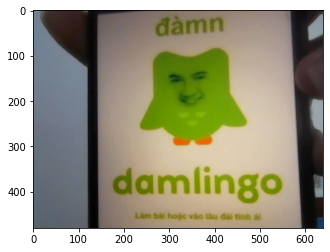

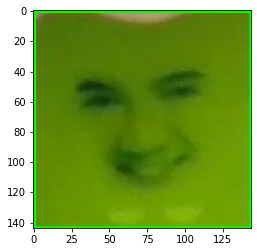

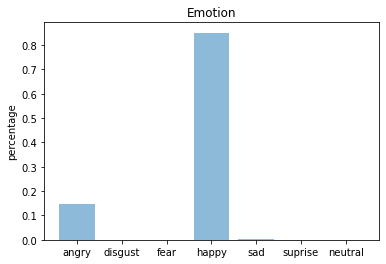

In [101]:
plt.imshow(image.load_img('/content/photo.jpg'))
plt.show()


inp_img_dir = '/content/capture.jpg'
inp_img = image.load_img(inp_img_dir)

plt.imshow(inp_img)
plt.show()

img_arr = image.img_to_array(inp_img)               # Convert hình ảnh thành mảng numpy 1 chiều
img_arr = np.expand_dims(img_arr, axis = 0)         # Thêm trục vị trí 0 cho mảng numpy      (https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)
img_arr /= 255

img_pred = model.predict(img_arr)
emotion_predict(img_pred[0])

img_arr = np.array(img_arr, 'float32')
img_arr = np.squeeze(img_arr, axis = 0)